In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
## 1. Perform data quality checks
# Load dataset
df = pd.read_csv('HR_comma_sep.csv')

# Check for missing values in each column
missing_values = df.isnull().sum()

# Calculate percentage of missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Missing values summary table
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})
print(missing_data)

                       Missing Values  Percentage (%)
satisfaction_level                  0             0.0
last_evaluation                     0             0.0
number_project                      0             0.0
average_montly_hours                0             0.0
time_spend_company                  0             0.0
Work_accident                       0             0.0
left                                0             0.0
promotion_last_5years               0             0.0
sales                               0             0.0
salary                              0             0.0


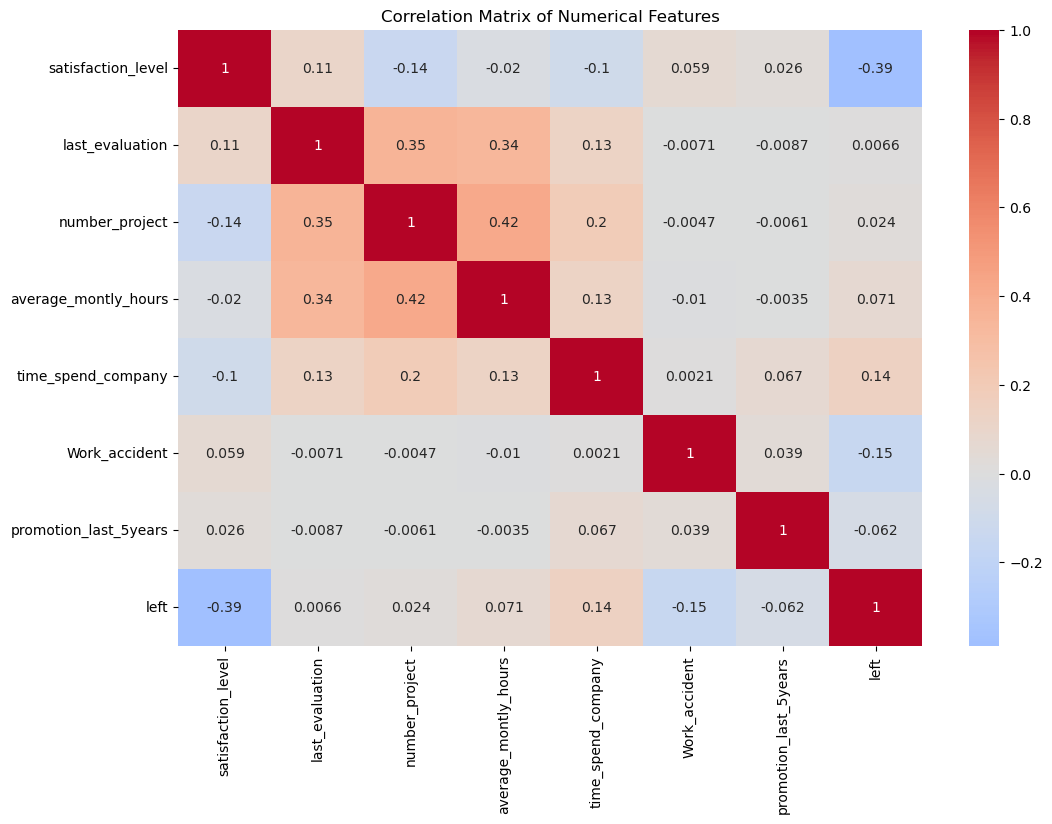

In [5]:
## 2. EDA
## 2.1 Draw a heatmap of the correlation matrix
# Select numerical columns
numerical_cols = ['satisfaction_level', 'last_evaluation', 'number_project',
                 'average_montly_hours', 'time_spend_company', 'Work_accident',
                 'promotion_last_5years']

# Calculate correlation matrix
corr_matrix = df[numerical_cols + ['left']].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

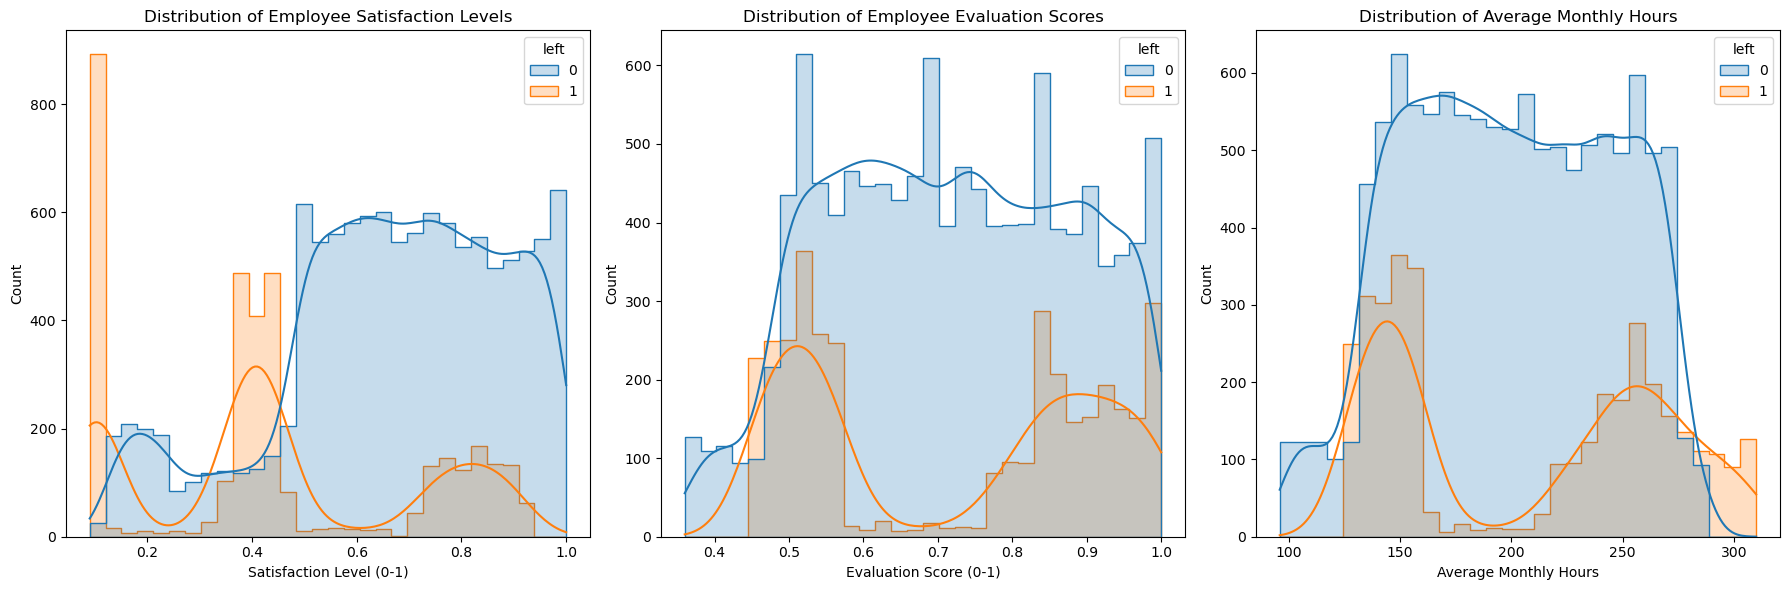

In [6]:
## 2.2 Draw the distribution plot of:
## a) Employee Satisfaction (use column satisfaction_level)
## b) Employee Evaluation (use column last_evaluation)
## c) Employee Average Monthly Hours (use column average_montly_hours)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=df, x='satisfaction_level', hue='left', element='step', ax=axes[0], bins=30, kde=True)
axes[0].set_title('Distribution of Employee Satisfaction Levels')
axes[0].set_xlabel('Satisfaction Level (0-1)')
axes[0].set_ylabel('Count')

sns.histplot(data=df, x='last_evaluation', hue='left', element='step', ax=axes[1], bins=30, kde=True)
axes[1].set_title('Distribution of Employee Evaluation Scores')
axes[1].set_xlabel('Evaluation Score (0-1)')
axes[1].set_ylabel('Count')

sns.histplot(data=df, x='average_montly_hours', hue='left', element='step', ax=axes[2], bins=30, kde=True)
axes[2].set_title('Distribution of Average Monthly Hours')
axes[2].set_xlabel('Average Monthly Hours')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

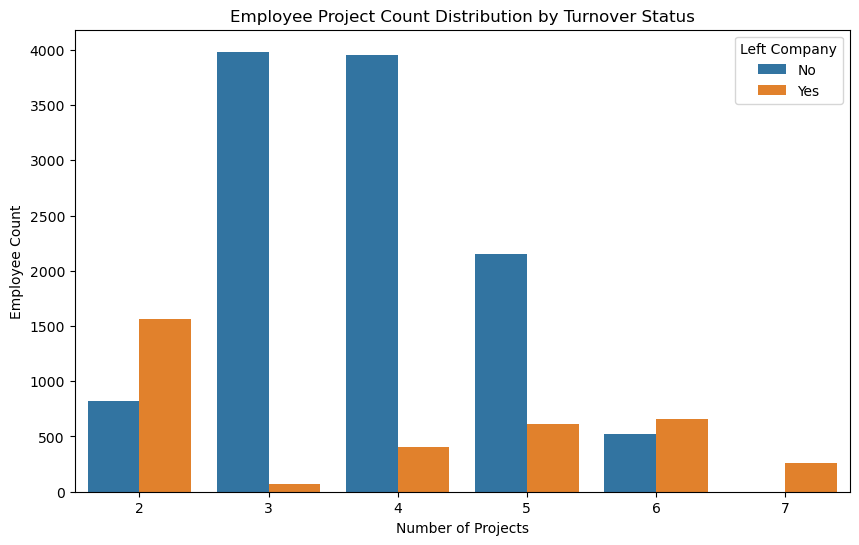

In [7]:
## 2.3 Draw the bar plot of the employee project count of both employees who left and stayed in the organization
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='number_project', hue='left')
plt.title('Employee Project Count Distribution by Turnover Status')
plt.xlabel('Number of Projects')
plt.ylabel('Employee Count')
plt.legend(title='Left Company', labels=['No', 'Yes'])
plt.show()

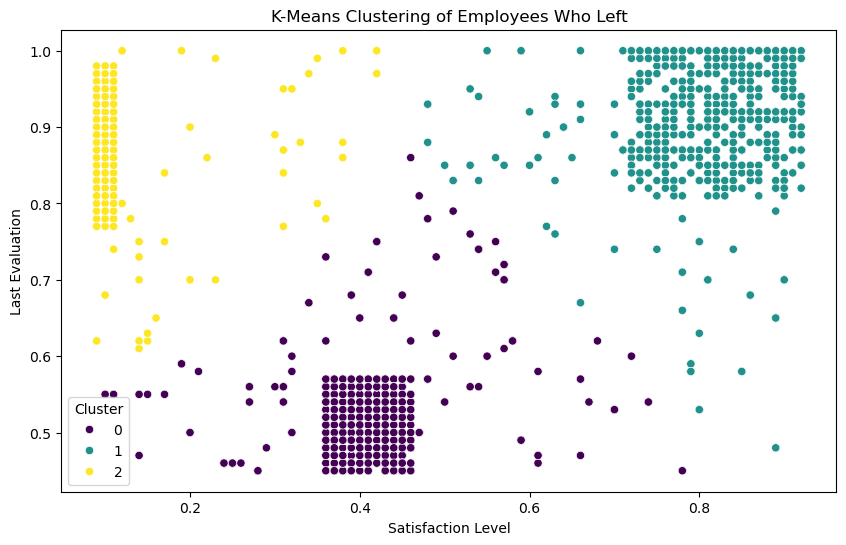

         satisfaction_level  last_evaluation
cluster                                     
0                  0.410145         0.516982
1                  0.808516         0.911709
2                  0.111155         0.869301


In [8]:
## 3. Perform clustering of employees who left based on their satisfaction and evaluation.
## a) Choose columns satisfaction_level, last_evaluation, and left.
## b) Do K-means clustering of employees who left the company into 3 clusters?
## c) Based on the satisfaction and evaluation factors, give your thoughts on the employee clusters.

# Select employees who left
left_employees = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]

# Apply K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
left_employees['cluster'] = kmeans.fit_predict(left_employees)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=left_employees, x='satisfaction_level', y='last_evaluation', hue='cluster', palette='viridis')
plt.title("K-Means Clustering of Employees Who Left")
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation")
plt.legend(title="Cluster")
plt.show()

# Calculate cluster means
cluster_summary = left_employees.groupby('cluster').mean()
print(cluster_summary)

In [9]:
# Count employees in each cluster
cluster_counts = left_employees['cluster'].value_counts()
print("\nEmployee count per cluster:")
print(cluster_counts)


Employee count per cluster:
cluster
0    1650
1     977
2     944
Name: count, dtype: int64


In [10]:
## 4. Handle the left Class Imbalance using the SMOTE technique.
## 4.1. Pre-process the data by converting categorical columns to numerical columns by:
## a) Separating categorical variables and numeric variables
## b) Applying get_dummies() to the categorical variables
## c) Combining categorical variables and numeric variables
## 4.2. Do the stratified split of the dataset to train and test in the ratio 80:20 with random_state=123.
## 4.3. Upsample the train dataset using the SMOTE technique from the imblearn module.

## 4.1 Separate categorical and numerical variables
# Identify categorical columns
categorical_cols = ['sales', 'salary', 'Work_accident', 'promotion_last_5years']  # Including binary categoricals
numeric_cols = ['satisfaction_level', 'last_evaluation', 'number_project',
               'average_montly_hours', 'time_spend_company']

# Target variable
target_col = 'left'

# Convert categorical variables using one-hot encoding
categorical_df = pd.get_dummies(df[categorical_cols], drop_first=True)

# Combine numeric and encoded categorical variables
processed_df = pd.concat([df[numeric_cols], categorical_df, df[target_col]], axis=1)

In [11]:
## 4.2 Stratified Train-Test Split (80:20)
# Separate features and target
X = processed_df.drop(target_col, axis=1)
y = processed_df[target_col]

# Stratified split (preserves class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=123,
    stratify=y
)

# Check class distribution before SMOTE
print("Original class distribution:")
print(y_train.value_counts())
print(f"\nImbalance ratio: {y_train.value_counts()[0]/y_train.value_counts()[1]:.2f}:1")

Original class distribution:
left
0    9142
1    2857
Name: count, dtype: int64

Imbalance ratio: 3.20:1


In [12]:
## 4.3 Applying SMOTE
# Apply SMOTE only to training data
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

# Verify shapes
print(f"\nX_train shape before SMOTE: {X_train.shape}")
print(f"X_train shape after SMOTE: {X_train_smote.shape}")


Class distribution after SMOTE:
left
0    9142
1    9142
Name: count, dtype: int64

X_train shape before SMOTE: (11999, 18)
X_train shape after SMOTE: (18284, 18)


In [13]:
## 5. Perform 5-fold cross-validation model training and evaluate performance.
## 5.1. Train a logistic regression model, apply a 5-fold CV, and plot the classification report.
## 5.2. Train a Random Forest Classifier model, apply the 5-fold CV, and plot the classification report.
## 5.3. Train a Gradient Boosting Classifier model, apply the 5-fold CV, and plot the classification report.

## 5.1 Logistic Regression with 5-fold CV
# Initialize model
logreg = LogisticRegression(max_iter=1000, random_state=123)

# 5-fold cross-validation predictions
y_pred_logreg = cross_val_predict(logreg, X_train_smote, y_train_smote, cv=5)

# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_train_smote, y_pred_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      9142
           1       0.78      0.82      0.80      9142

    accuracy                           0.80     18284
   macro avg       0.80      0.80      0.79     18284
weighted avg       0.80      0.80      0.79     18284



In [14]:
## 5.2 Random Forest Classifier with 5-fold CV
# Initialize model
rf = RandomForestClassifier(random_state=123)

# 5-fold cross-validation predictions
y_pred_rf = cross_val_predict(rf, X_train_smote, y_train_smote, cv=5)

# Classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_train_smote, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9142
           1       1.00      0.97      0.98      9142

    accuracy                           0.98     18284
   macro avg       0.98      0.98      0.98     18284
weighted avg       0.98      0.98      0.98     18284



In [15]:
## 5.3 Gradient Boosting Classifier with 5-fold CV
# Initialize model
gb = GradientBoostingClassifier(random_state=123)

# 5-fold cross-validation predictions
y_pred_gb = cross_val_predict(gb, X_train_smote, y_train_smote, cv=5)

# Classification report
print("\nGradient Boosting Classification Report:")
print(classification_report(y_train_smote, y_pred_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      9142
           1       0.98      0.95      0.96      9142

    accuracy                           0.96     18284
   macro avg       0.96      0.96      0.96     18284
weighted avg       0.96      0.96      0.96     18284



In [16]:
## 6. Identify the best model and justify the evaluation metrics used.
## 6.1. Find the ROC/AUC for each model and plot the ROC curve.
## 6.2. Find the confusion matrix for each of the models.
## 6.3. Explain which metric needs to be used from the confusion matrix: Recall or Precision?

## 6.1 ROC/AUC Analysis and Plotting
# Function to get cross-validated probabilities
def get_cv_proba(model, X, y, cv=5):
    return cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

# Get predicted probabilities for each model
logreg_probs = get_cv_proba(LogisticRegression(max_iter=1000, random_state=123),
                          X_train_smote, y_train_smote)
rf_probs = get_cv_proba(RandomForestClassifier(random_state=123),
                      X_train_smote, y_train_smote)
gb_probs = get_cv_proba(GradientBoostingClassifier(random_state=123),
                      X_train_smote, y_train_smote)

# Calculate ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_train_smote, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_train_smote, rf_probs)
fpr_gb, tpr_gb, _ = roc_curve(y_train_smote, gb_probs)

# Calculate AUC scores
auc_logreg = roc_auc_score(y_train_smote, logreg_probs)
auc_rf = roc_auc_score(y_train_smote, rf_probs)
auc_gb = roc_auc_score(y_train_smote, gb_probs)

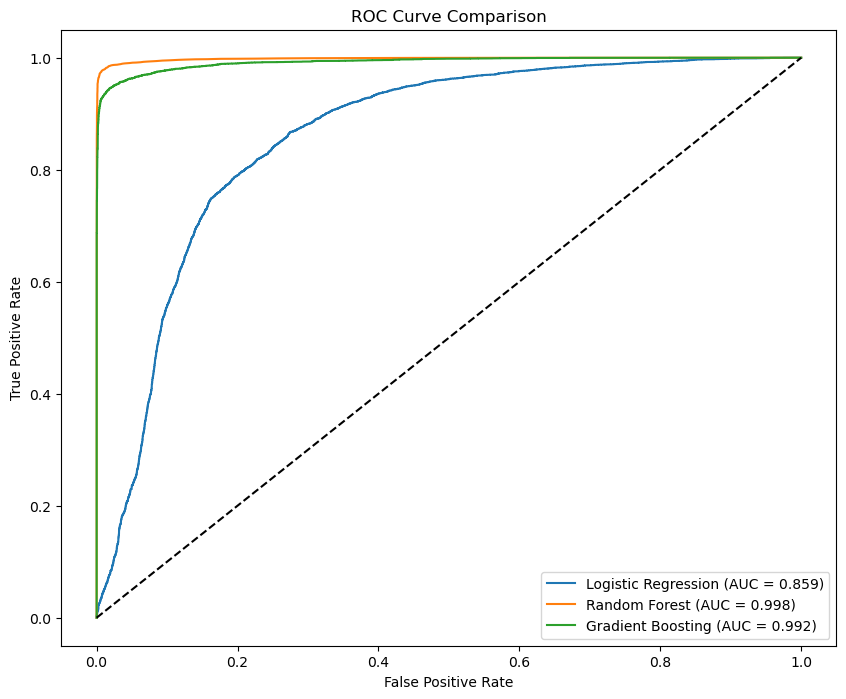

In [17]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

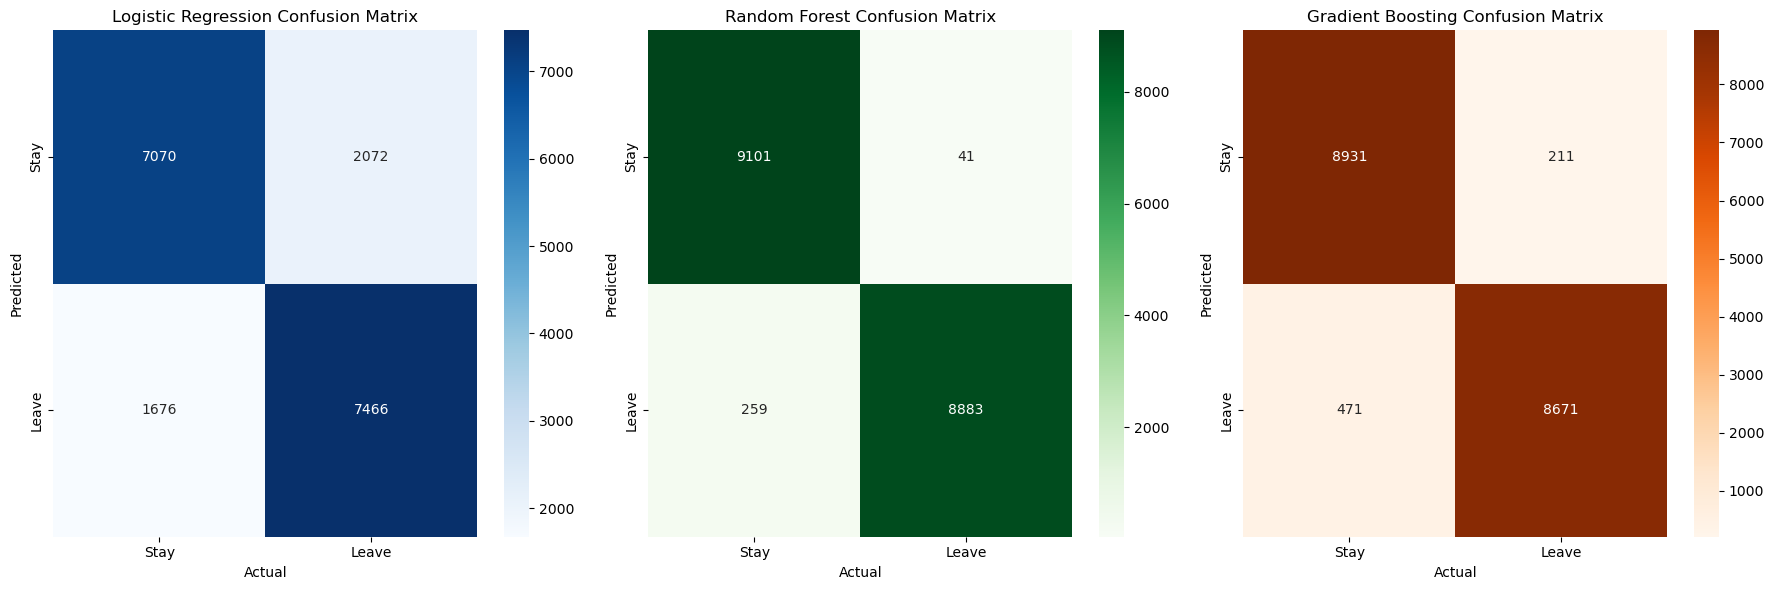

In [18]:
## 6.2 Confusion Matrices for All Models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(confusion_matrix(y_train_smote, y_pred_logreg),
            annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Stay', 'Leave'],
            yticklabels=['Stay', 'Leave'])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

sns.heatmap(confusion_matrix(y_train_smote, y_pred_rf),
            annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Stay', 'Leave'],
            yticklabels=['Stay', 'Leave'])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

sns.heatmap(confusion_matrix(y_train_smote, y_pred_gb),
            annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=['Stay', 'Leave'],
            yticklabels=['Stay', 'Leave'])
axes[2].set_title('Gradient Boosting Confusion Matrix')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

In [19]:
## 7. Suggest various retention strategies for targeted employees.
## 7.1. Using the best model, predict the probability of employee turnover in the test data.
## 7.2. Based on the probability score range below, categorize the employees into four zones and suggest your thoughts on the retention strategies for each zone.
## - Safe Zone (Green) (Score < 20%)
## - Low-Risk Zone (Yellow) (20% < Score < 60%)
## - Medium-Risk Zone (Orange) (60% < Score < 90%)
## - High-Risk Zone (Red) (Score > 90%).

## 7.1 Predict the probability of Employee Turnover
# Train the best model (Gradient Boosting) on full SMOTE training data
best_model = GradientBoostingClassifier(random_state=123)
best_model.fit(X_train_smote, y_train_smote)

# Predict probabilities on test data
test_probs = best_model.predict_proba(X_test)[:, 1]  # Probability of leaving

# Add probabilities to test data
test_data = X_test.copy()
test_data['left_prob'] = test_probs
test_data['actual'] = y_test

In [20]:
## 7.2 Categorize the employees into four zones
# Categorize employees into risk zones
def categorize_risk(prob):
    if prob < 0.2:
        return 'Safe Zone (Green)'
    elif 0.2 <= prob < 0.6:
        return 'Low-Risk Zone (Yellow)'
    elif 0.6 <= prob < 0.9:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'

test_data['risk_zone'] = test_data['left_prob'].apply(categorize_risk)

In [21]:
# Distribution of employees across risk zones
zone_distribution = test_data['risk_zone'].value_counts(normalize=True) * 100
print("Employee Distribution Across Risk Zones:")
print(zone_distribution)

Employee Distribution Across Risk Zones:
risk_zone
Safe Zone (Green)            69.700000
High-Risk Zone (Red)         20.533333
Low-Risk Zone (Yellow)        7.000000
Medium-Risk Zone (Orange)     2.766667
Name: proportion, dtype: float64


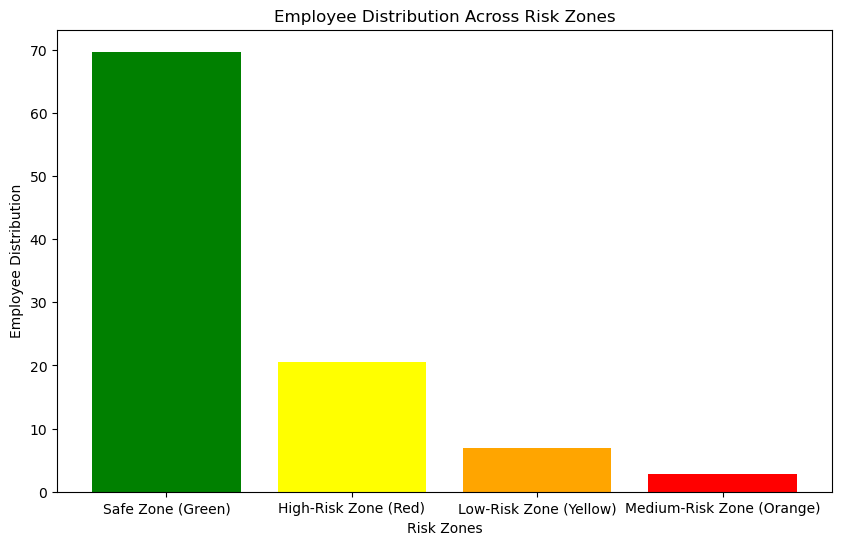

In [68]:
# Distribution of employees across risk zones
risk_data = zone_distribution.to_dict()

# Extract keys and values
risk_keys = list(risk_data.keys())
risk_values = list(risk_data.values())

# Plot bar chart
plt.figure(figsize=(10, 6))

plt.bar(risk_keys, risk_values, color=['green', 'yellow', 'orange', 'red'])
plt.title("Employee Distribution Across Risk Zones")
plt.xlabel("Risk Zones")
plt.ylabel("Employee Distribution")
plt.show()